In [1]:
# Install required packages
#!pip install torch torchvision transformers pandas pillow requests matplotlib tqdm ipywidgets gradio torch-fidelity

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from transformers import AutoTokenizer
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Using device: cpu


In [2]:
import torch
import torchvision.transforms as T


class AugmentationPipeline:
    def __init__(self, p=0.8):
        self.p = p
        self.transforms = T.RandomApply([
            T.RandomHorizontalFlip(p=0.5),

            T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=1),

            T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),

            T.RandomErasing(p=0.15, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
        ], p=self.p)

    def apply(self, images):
        return self.transforms(images)

dataset\pokedex-main already exists. Skipping download.
Dataset ready!
Creating training setup with train/val split and fixed batches...
Dataset caricato: 898 Pokemon con descrizioni e immagini
Dataset caricato: 898 Pokemon con descrizioni e immagini
Training setup complete!
Train loader batches: 51
Val loader batches: 6

Fixed batch shapes:
  Train batch - Images: torch.Size([4, 3, 256, 256])
  Train batch - Text: torch.Size([4, 128])
  Train batch - Attention: torch.Size([4, 128])
  Val batch - Images: torch.Size([4, 3, 256, 256])


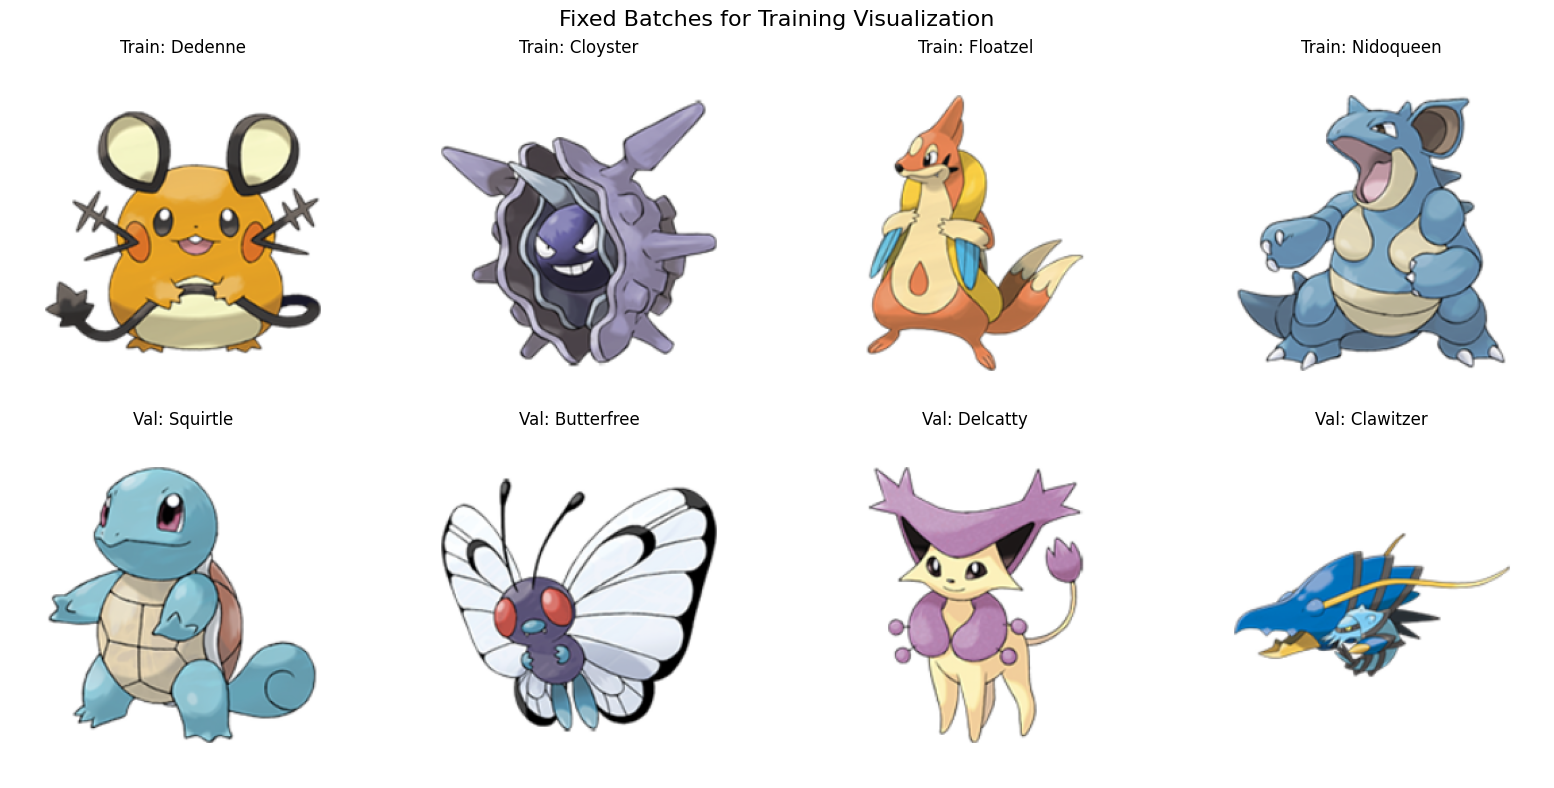


✅ Dataset and batches loaded successfully from pokemon_dataset.py functionality!
Ready for training with proper train/val split and fixed visualization batches.


In [3]:
from data_loader import create_training_setup
from utils import denormalize_image

tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-mini')

# train_augmentation_pipeline = AugmentationPipeline()
# Create the complete training setup using the function from pokemon_dataset.py
print("Creating training setup with train/val split and fixed batches...")
training_setup = create_training_setup(
    tokenizer=tokenizer,
    train_val_split=0.9,
    batch_size=16,
    num_workers=0,
    num_viz_samples=4,
    random_seed=42,
    train_augmentation_pipeline=None
)

# Extract components
train_loader = training_setup['train_loader']
val_loader = training_setup['val_loader']
fixed_train_batch = training_setup['fixed_train_batch']
fixed_val_batch = training_setup['fixed_val_batch']
fixed_train_attention_batch = training_setup['fixed_train_attention_batch']
fixed_val_attention_batch = training_setup['fixed_val_attention_batch']

print("Training setup complete!")
print(f"Train loader batches: {len(train_loader)}")
print(f"Val loader batches: {len(val_loader)}")

# Test the training setup with fixed batches
print("\nFixed batch shapes:")
print(f"  Train batch - Images: {fixed_train_batch['image'].shape}")
print(f"  Train batch - Text: {fixed_train_batch['text'].shape}")
print(f"  Train batch - Attention: {fixed_train_batch['attention_mask'].shape}")
print(f"  Val batch - Images: {fixed_val_batch['image'].shape}")

# Display sample images from fixed batches
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    # Fixed train batch images
    train_img = denormalize_image(fixed_train_batch['image'][i])
    axes[0, i].imshow(train_img.permute(1, 2, 0))
    axes[0, i].set_title(f"Train: {fixed_train_batch['pokemon_name'][i]}")
    axes[0, i].axis('off')

    # Fixed val batch images
    val_img = denormalize_image(fixed_val_batch['image'][i])
    axes[1, i].imshow(val_img.permute(1, 2, 0))
    axes[1, i].set_title(f"Val: {fixed_val_batch['pokemon_name'][i]}")
    axes[1, i].axis('off')

plt.suptitle("Fixed Batches for Training Visualization", fontsize=16)
plt.tight_layout()
plt.show()


print("\n✅ Dataset and batches loaded successfully from pokemon_dataset.py functionality!")
print("Ready for training with proper train/val split and fixed visualization batches.")


Generator output shape 256x256: torch.Size([2, 3, 256, 256])
Generator output shape 64x64: torch.Size([2, 3, 64, 64])


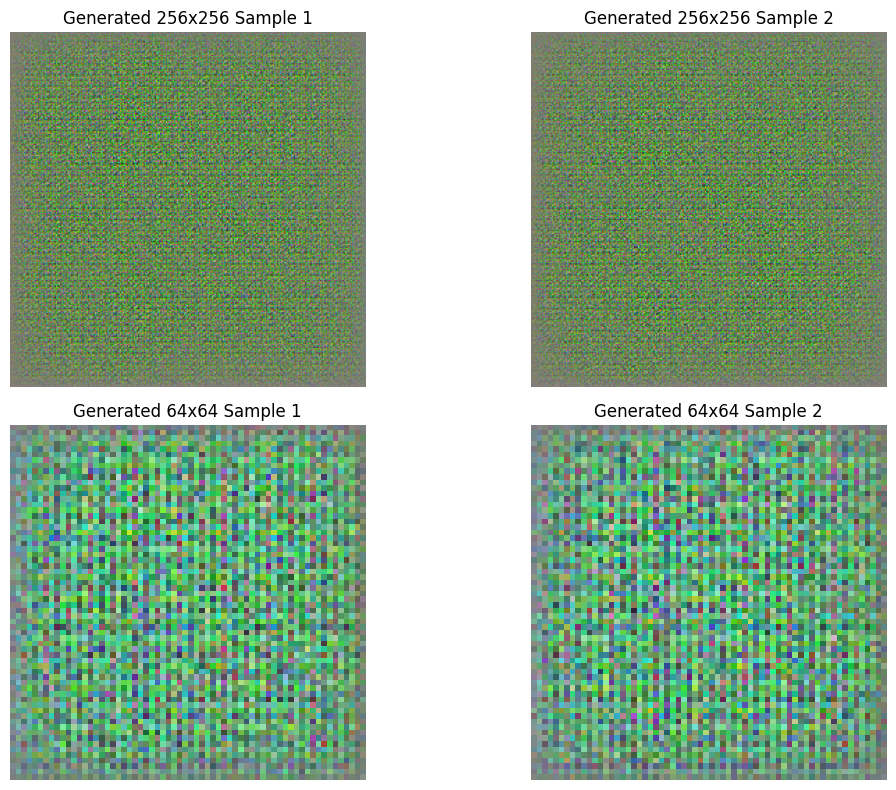

✅ Generator test successful!


In [ ]:
from model import Generator

# Test the generator
generator = Generator().to(device)
with torch.no_grad():
    generated_images_256, generated_images_64 = generator(
        fixed_train_batch['text'][:2].to(device),
        fixed_train_batch['attention_mask'][:2].to(device)
    )
print(f"Generator output shape 256x256: {generated_images_256.shape}")
print(f"Generator output shape 64x64: {generated_images_64.shape}")

print("Generator test")
plt.figure(figsize=(12, 8))
for i in range(2):
    # 256x256 images
    plt.subplot(2, 2, i+1)
    img_256 = denormalize_image(generated_images_256[i].cpu())
    plt.imshow(img_256.permute(1, 2, 0))
    plt.title(f"Generated 256x256 Sample {i+1}")
    plt.axis('off')

    # 64x64 images
    plt.subplot(2, 2, i+3)
    img_64 = denormalize_image(generated_images_64[i].cpu())
    plt.imshow(img_64.permute(1, 2, 0))
    plt.title(f"Generated 64x64 Sample {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from discriminators import Discriminator256, Discriminator64
from losses import VGGPerceptualLoss, SobelLoss
from plots import save_attention_visualization

def weights_init(m):
    """Initialize model weights according to the original DCGAN paper"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator = Generator().to(device)
discriminator_256 = Discriminator256().to(device)
discriminator_64 = Discriminator64().to(device)

generator.apply(weights_init)
discriminator_256.apply(weights_init)
discriminator_64.apply(weights_init)


# Optimizer params
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_256 = optim.Adam(discriminator_256.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_64 = optim.Adam(discriminator_64.parameters(), lr=lr, betas=(beta1, beta2))

adv_criterion = nn.BCEWithLogitsLoss().to(device)  # no sigmoid at the end of discriminators
l1_criterion = nn.L1Loss().to(device)
perc_criterion = VGGPerceptualLoss(device)
sobel_criterion = SobelLoss().to(device)

Models and optimizers initialized successfully!
Generator parameters: 17,001,559
Discriminator 256 parameters: 31,994,562
Discriminator 64 parameters: 16,788,674
Total parameters: 65,784,795


In [ ]:
from typing import TypedDict
import torch
from plots import save_comparison_grid

# Create checkpoint saving directory
os.makedirs('models', exist_ok=True)

# TypedDicts to pass and return many object at once, without
class LossesDict(TypedDict):
    """History of training losses"""
    generator: list[float]
    discriminator: list[float]
    l1: list[float]
    perceptual: list[float]
    sobel: list[float]

class ValidationLossesDict(TypedDict):
    """History of validation losses"""
    l1: list[float]
    perceptual: list[float]
    sobel: list[float]
    total: list[float]

class DiscriminatorComponentsDict(TypedDict):
    """Components of the discriminator loss"""
    real_uncond: float
    real_cond: float
    real_cond_wrong: float
    fake_uncond: float

class ValidationResultsDict(TypedDict):
    """Single losses for validation"""
    l1: float
    perceptual: float
    sobel: float
    total: float

# Training history
losses: LossesDict = {
    'generator': [],
    'discriminator': [],
    'l1': [],
    'perceptual': [],
    'sobel': [],
}

# Validation history
val_losses: ValidationLossesDict = {
    'l1': [],
    'perceptual': [],
    'sobel': [],
    'total': [],
}

def validate_model(generator, val_loader, device, l1_criterion, perc_criterion, sobel_criterion) -> ValidationResultsDict:
    """
    Validate the model on the validation set
    Returns validation losses
    """
    generator.eval()

    val_l1_loss = 0.0
    val_perc_loss = 0.0
    val_sobel_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in val_loader:
            # Move data to device
            real_images = batch['image'].to(device)
            text_ids = batch['text'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Generate images
            generated_images, _ = generator(text_ids, attention_mask)

            # Calculate validation losses (no adversarial loss)
            batch_l1_loss = l1_criterion(generated_images, real_images)
            batch_perc_loss = perc_criterion(generated_images, real_images)
            batch_sobel_loss = sobel_criterion(generated_images, real_images)

            val_l1_loss += batch_l1_loss.item()
            val_perc_loss += batch_perc_loss.item()
            val_sobel_loss += batch_sobel_loss.item()
            num_batches += 1

    # Calculate averages
    avg_val_l1 = val_l1_loss / num_batches
    avg_val_perc = val_perc_loss / num_batches
    avg_val_sobel = val_sobel_loss / num_batches
    avg_val_total = avg_val_l1 + avg_val_perc + avg_val_sobel

    # Set models back to training mode
    generator.train()

    return ValidationResultsDict(
        l1=avg_val_l1,
        perceptual=avg_val_perc,
        sobel=avg_val_sobel,
        total=avg_val_total
    )

def create_mismatched_text_batch(text_ids, attention_mask):
    """Create a batch with mismatched text for wrong text conditioning"""
    batch_size = text_ids.size(0)
    indices = torch.randperm(batch_size)
    return text_ids[indices], attention_mask[indices]

def compute_discriminator_loss(
    discriminator,
    real_images,
    fake_images,
    text_ids,
    attention_mask,
    wrong_text_ids,
    wrong_attention_mask,
    real_labels,
    fake_labels,
    adv_criterion
) -> tuple[torch.Tensor, DiscriminatorComponentsDict]:
    """Compute discriminator loss with the 4 components.
    Returns the total loss and the 4 components."""
    # Real images with correct text
    real_uncond, real_cond = discriminator(real_images, text_ids, attention_mask, return_both=True)
    real_uncond_loss = adv_criterion(real_uncond, real_labels)
    real_cond_loss = adv_criterion(real_cond, real_labels)

    # Real images with wrong text
    _, real_cond_wrong = discriminator(real_images, wrong_text_ids, wrong_attention_mask, return_both=True)
    real_cond_wrong_loss = adv_criterion(real_cond_wrong, fake_labels)

    # Fake images with wrong text
    fake_uncond, _ = discriminator(fake_images.detach(), wrong_text_ids, wrong_attention_mask, return_both=True)
    fake_uncond_loss = adv_criterion(fake_uncond, fake_labels)

    total_loss = (real_uncond_loss + real_cond_loss + real_cond_wrong_loss + fake_uncond_loss) / 4

    components: DiscriminatorComponentsDict = {
        'real_uncond': real_uncond_loss.item(),
        'real_cond': real_cond_loss.item(),
        'real_cond_wrong': real_cond_wrong_loss.item(),
        'fake_uncond': fake_uncond_loss.item(),
    }

    return total_loss, components

def compute_generator_adversarial_loss(
    discriminator,
    fake_images,
    text_ids,
    attention_mask,
    real_labels,
    adv_criterion
) -> torch.Tensor:
    """Compute generator adversarial loss for one discriminator"""
    fake_uncond, fake_cond = discriminator(fake_images, text_ids, attention_mask, return_both=True)
    uncond_loss = adv_criterion(fake_uncond, real_labels)
    cond_loss = adv_criterion(fake_cond, real_labels)
    return (uncond_loss + cond_loss) / 2

def compute_loss(fake_images, real_images, criterion, lmd):
    """Compute a reconstruction loss only if its lambda > 0"""
    return criterion(fake_images, real_images) if lmd > 0 else torch.tensor(0.0, device=device)


epoch = 0
noise_dim = 100


In [ ]:
from IPython.display import clear_output

total_epochs = 150
display_interval = 1  # To show generation of training sample
save_interval = 15  # To save checkpoint
clear_interval = 22  # To clear cell output. If too high or not present, Kaggle page would crash

lambda_l1 = 1.0
lambda_adv = 1.0
lambda_perceptual = 0.0
lambda_sobel = 0.0

real_label = 1.0
fake_label = 0.0

print("Starting training with dual discriminators...")

for epoch in range(epoch, total_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss_64 = 0.0
    epoch_d_loss_256 = 0.0
    epoch_l1_loss = 0.0
    epoch_perc_loss = 0.0
    epoch_sobel_loss = 0.0

    # Track discriminator loss components
    epoch_d256_components: DiscriminatorComponentsDict = {'real_uncond': 0.0, 'real_cond': 0.0, 'real_cond_wrong': 0.0, 'fake_uncond': 0.0}
    epoch_d64_components: DiscriminatorComponentsDict = {'real_uncond': 0.0, 'real_cond': 0.0, 'real_cond_wrong': 0.0, 'fake_uncond': 0.0}

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}")

    for i, batch in enumerate(progress_bar):
        batch_size = batch['image'].size(0)

        # Move data to device
        real_images = batch['image'].to(device)
        text_ids = batch['text'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Create labels and mismatched text for GAN training
        real_labels = torch.full((batch_size, 1), real_label, device=device, dtype=torch.float)
        fake_labels = torch.full((batch_size, 1), fake_label, device=device, dtype=torch.float)
        wrong_text_ids, wrong_attention_mask = create_mismatched_text_batch(text_ids, attention_mask)

        # Generate fake images
        fake_images_256, fake_images_64 = generator(text_ids, attention_mask)
        real_images_64 = F.interpolate(real_images, size=(64, 64), mode='bilinear', align_corners=False)

        # Training both discriminators
        optimizer_D_256.zero_grad()
        optimizer_D_64.zero_grad()

        d_loss_256, d256_components = compute_discriminator_loss(
            discriminator_256, real_images, fake_images_256,
            text_ids, attention_mask, wrong_text_ids, wrong_attention_mask,
            real_labels, fake_labels, adv_criterion
        )
        d_loss_256.backward()

        d_loss_64, d64_components = compute_discriminator_loss(
            discriminator_64, real_images_64, fake_images_64,
            text_ids, attention_mask, wrong_text_ids, wrong_attention_mask,
            real_labels, fake_labels, adv_criterion
        )
        d_loss_64.backward()

        optimizer_D_256.step()
        optimizer_D_64.step()

        # Training generator
        optimizer_G.zero_grad()

        # Adversarial losses for both discriminators
        g_adv_loss_256 = compute_generator_adversarial_loss(
            discriminator_256, fake_images_256, text_ids, attention_mask, real_labels, adv_criterion
        )
        g_adv_loss_64 = compute_generator_adversarial_loss(
            discriminator_64, fake_images_64, text_ids, attention_mask, real_labels, adv_criterion
        )
        adversarial_loss = (g_adv_loss_256 + g_adv_loss_64) / 2

        # Compute losses if their lambda is > 0
        l1_loss = compute_loss(fake_images_256, real_images, l1_criterion, lambda_l1)
        perc_loss = compute_loss(fake_images_256, real_images, perc_criterion, lambda_perceptual)
        sobel_loss = compute_loss(fake_images_256, real_images, sobel_criterion, lambda_sobel)

        # Total generator loss
        g_loss = (
            lambda_adv * adversarial_loss +
            lambda_l1 * l1_loss +
            lambda_perceptual * perc_loss +
            lambda_sobel * sobel_loss
        )
        g_loss.backward()
        optimizer_G.step()

        # Update loss tracking
        epoch_g_loss += g_loss.item()
        epoch_d_loss_256 += d_loss_256.item()
        epoch_d_loss_64 += d_loss_64.item()
        epoch_l1_loss += l1_loss.item()
        epoch_perc_loss += perc_loss.item()
        epoch_sobel_loss += sobel_loss.item()

        # Update discriminator component tracking
        for key in epoch_d256_components:
            epoch_d256_components[key] += d256_components[key]
            epoch_d64_components[key] += d64_components[key]

        # Update progress bar with detailed losses and loss components
        progress_bar.set_postfix({
            'G': f'{g_loss.item():.3f}',
            'L1': f'{l1_loss.item():.3f}',
            'Adv': f'{adversarial_loss.item():.3f}',
            'D256': f'{d_loss_256.item():.3f}',
            'D256_ru': f'{d256_components["real_uncond"]:.3f}',
            'D256_rc': f'{d256_components["real_cond"]:.3f}',
            'D256_rcw': f'{d256_components["real_cond_wrong"]:.3f}',
            'D256_fu': f'{d256_components["fake_uncond"]:.3f}',
            'D64': f'{d_loss_64.item():.3f}',
            'D64_ru': f'{d64_components["real_uncond"]:.3f}',
            'D64_rc': f'{d64_components["real_cond"]:.3f}',
            'D64_rcw': f'{d64_components["real_cond_wrong"]:.3f}',
            'D64_fu': f'{d64_components["fake_uncond"]:.3f}',
        })

    # Calculate average losses for the epoch
    avg_g_loss = epoch_g_loss / len(train_loader)
    avg_d_loss_256 = epoch_d_loss_256 / len(train_loader)
    avg_d_loss_64 = epoch_d_loss_64 / len(train_loader)
    avg_l1_loss = epoch_l1_loss / len(train_loader)
    avg_perc_loss = epoch_perc_loss / len(train_loader)
    avg_sobel_loss = epoch_sobel_loss / len(train_loader)

    # Calculate average discriminator components for epoch
    avg_d256_components = {key: val / len(train_loader) for key, val in epoch_d256_components.items()}
    avg_d64_components = {key: val / len(train_loader) for key, val in epoch_d64_components.items()}

    # Store losses (combine discriminator losses)
    losses['generator'].append(avg_g_loss)
    losses['discriminator'].append((avg_d_loss_256 + avg_d_loss_64) / 2)
    losses['l1'].append(avg_l1_loss)
    losses['perceptual'].append(avg_perc_loss)
    losses['sobel'].append(avg_sobel_loss)

    print(f"Running validation for epoch {epoch+1}...")
    validation_results = validate_model(generator, val_loader, device, l1_criterion, perc_criterion, sobel_criterion)

    # Store validation losses

    for k, v in validation_results.items():
        val_losses[k].append(v)

    if (epoch + 1) % clear_interval == 0:
        clear_output(wait=True)

    print(f"Epoch [{epoch+1}/{total_epochs}]")
    print(f"  Train - D_256: {avg_d_loss_256:.4f}, D_64: {avg_d_loss_64:.4f}, G_loss: {avg_g_loss:.4f}")
    print(f"  D_256 Components - RU: {avg_d256_components['real_uncond']:.4f}, RC: {avg_d256_components['real_cond']:.4f}, RCW: {avg_d256_components['real_cond_wrong']:.4f}, FU: {avg_d256_components['fake_uncond']:.4f}")
    print(f"  D_64 Components  - RU: {avg_d64_components['real_uncond']:.4f}, RC: {avg_d64_components['real_cond']:.4f}, RCW: {avg_d64_components['real_cond_wrong']:.4f}, FU: {avg_d64_components['fake_uncond']:.4f}")
    print(f"  Train - L1: {avg_l1_loss:.4f}, Perceptual: {avg_perc_loss:.4f}, Sobel: {avg_sobel_loss:.4f}")
    print(f"  Val   - L1: {validation_results['l1']:.4f}, Perceptual: {validation_results['perceptual']:.4f}, Sobel: {validation_results['sobel']:.4f}, Total: {validation_results['total']:.4f}")
    print("  Legend: RU=RealUncond, RC=RealCond, RCW=RealCondWrong, FU=FakeUncond")

    # Display generated images
    if (epoch + 1) % display_interval == 0:
        print(f"\nGenerating sample images at epoch {epoch+1}:")
        print("256x256 Training Images:")
        save_comparison_grid(epoch+1, generator, fixed_train_batch, "train_256", device, show_inline=True)
        print("64x64 Training Images:")
        save_comparison_grid(epoch+1, generator, fixed_train_batch, "train_64", device, show_inline=True)

    # Save checkpoint and show visualizations
    if (epoch + 1) % save_interval == 0:
        checkpoint_path = f'models/checkpoint_epoch_{epoch+1}.pth'
        all_losses = {'train': losses, 'val': val_losses}
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_256_state_dict': discriminator_256.state_dict(),
            'discriminator_64_state_dict': discriminator_64.state_dict(),
            'g_optimizer_state_dict': optimizer_G.state_dict(),
            'd_optimizer_state_dict': optimizer_D_256.state_dict(),
            'd_64_optimizer_state_dict': optimizer_D_64.state_dict(),
            'losses': all_losses
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

        print("256x256 Validation Images:")
        save_comparison_grid(epoch+1, generator, fixed_val_batch, "val_256", device, show_inline=True)
        print("64x64 Validation Images:")
        save_comparison_grid(epoch+1, generator, fixed_val_batch, "val_64", device, show_inline=True)
        save_attention_visualization(epoch+1, generator, tokenizer, fixed_train_batch, device, "train", show_inline=True)
        save_attention_visualization(epoch+1, generator, tokenizer, fixed_val_batch, device, "val", show_inline=True)

print("Training completed!")


Starting training with dual discriminators...


Epoch 1/150:  22%|██▏       | 11/51 [01:31<06:22,  9.56s/it, G=4.344, L1=0.843, Adv=3.500, D256=0.485, D256_ru=0.196, D256_rc=1.405, D256_rcw=0.331, D256_fu=0.007, D64=0.690, D64_ru=0.526, D64_rc=0.620, D64_rcw=0.857, D64_fu=0.756]

Grafico delle loss salvato in: training_output\training_losses.png


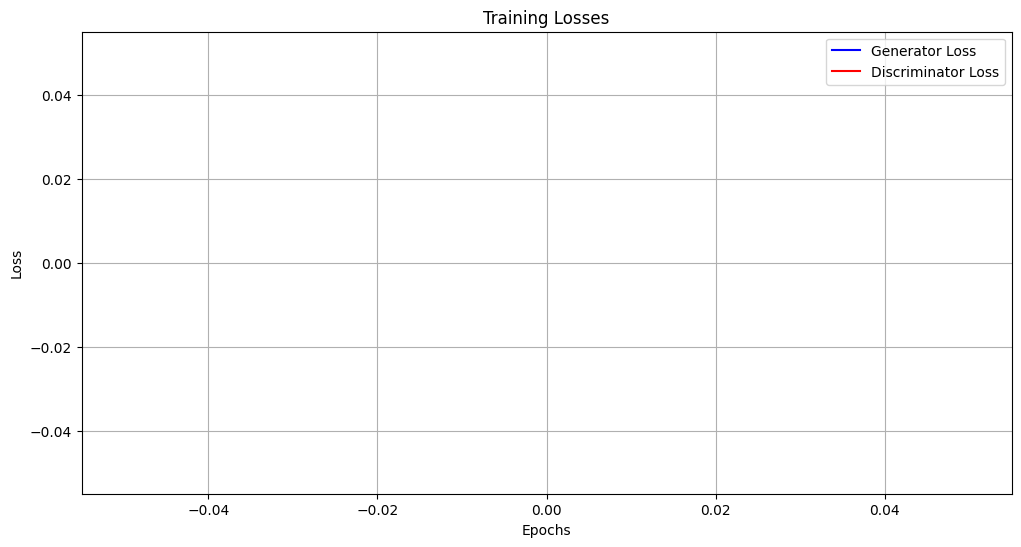

No loss history to plot


IndexError: list index out of range

In [ ]:
from plots import save_plot_losses, save_plot_non_gan_losses


save_plot_losses(
    losses_g=losses['generator'],
    losses_d=losses['discriminator'],
    output_dir="training_output",
    show_inline=True
)

# Plot training vs validation losses for non-GAN components (so except "generator" and "discriminator" from losses)
# Convert to list of dicts format expected by save_plot_non_gan_losses
train_losses_history = []
val_losses_history = []

for i in range(len(losses['l1'])):
    train_losses_history.append({
        'l1': losses['l1'][i],
        'perceptual': losses['perceptual'][i],
        'sobel': losses['sobel'][i],
        'total': losses['l1'][i] + losses['perceptual'][i] + losses['sobel'][i]
    })

for i in range(len(val_losses['l1'])):
    val_losses_history.append({
        'l1': val_losses['l1'][i],
        'perceptual': val_losses['perceptual'][i],
        'sobel': val_losses['sobel'][i],
        'total': val_losses['total'][i]
    })

save_plot_non_gan_losses(
    train_losses_history=train_losses_history,
    val_losses_history=val_losses_history,
    output_dir="training_output",
    show_inline=True
)

# Print final statistics
print(f"Final Train - Generator Loss: {losses['generator'][-1]:.4f}")
print(f"Final Train - Discriminator Loss: {losses['discriminator'][-1]:.4f}")
print(f"Final Train - L1 Loss: {losses['l1'][-1]:.4f}")
print(f"Final Train - Perceptual Loss: {losses['perceptual'][-1]:.4f}")
print(f"Final Train - Sobel Loss: {losses['sobel'][-1]:.4f}")

print(f"Final Val   - L1 Loss: {val_losses['l1'][-1]:.4f}")
print(f"Final Val   - Perceptual Loss: {val_losses['perceptual'][-1]:.4f}")
print(f"Final Val   - Sobel Loss: {val_losses['sobel'][-1]:.4f}")
print(f"Final Val   - Total Loss: {val_losses['total'][-1]:.4f}")


In [ ]:
# Generate a grid of final results
print("Final Results - Generated Pokemon Sprites (256x256):")
batch = next(iter(train_loader))
save_comparison_grid(0, generator, batch, "final_256", device, show_inline=True)

print("Final Results - Generated Pokemon Sprites (64x64):")
save_comparison_grid(0, generator, batch, "final_64", device, show_inline=True)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Generator parameters: {count_parameters(generator):,}")
print(f"Discriminator (256) parameters: {count_parameters(discriminator_256):,}")
print(f"Discriminator (64) parameters: {count_parameters(discriminator_64):,}")
